In [80]:
import pandas as pd

In [81]:
df = pd.read_csv('./training_data_08-24-2022-20-50-31.csv')

# Analyse Data

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2561 non-null   int64  
 1   i_sensor_1  2561 non-null   int64  
 2   i_sensor_2  2561 non-null   int64  
 3   i_sensor_3  2561 non-null   int64  
 4   o_left      2561 non-null   bool   
 5   o_right     2561 non-null   bool   
 6   i_sensor_4  2561 non-null   float64
 7   i_sensor_5  2561 non-null   float64
dtypes: bool(2), float64(2), int64(4)
memory usage: 125.2 KB


<AxesSubplot:>

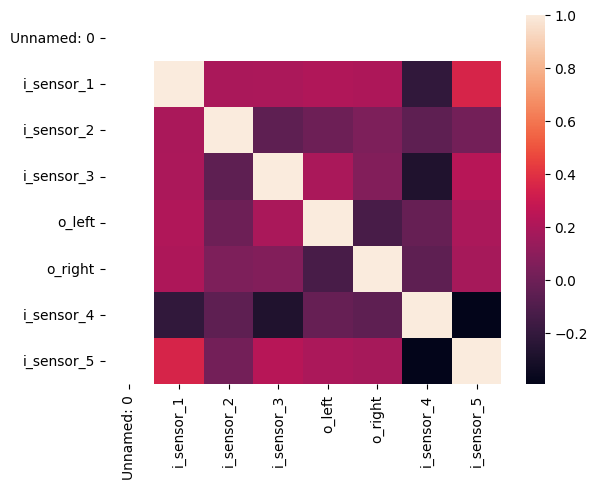

In [83]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [84]:
df = df.astype({'o_left': int, 'o_right': int})   

In [85]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
0,0,-1,183,79,0,0,180.0,70.0
1,0,-1,173,79,0,0,180.0,70.0
2,0,-1,163,79,0,0,180.0,69.0
3,0,-1,153,79,0,0,180.0,70.0
4,0,-1,143,79,0,0,180.0,70.0


In [86]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
317,0,275,282,206,1,0,60.0,164.0
318,0,293,278,222,1,0,60.0,168.0
319,0,271,275,248,1,0,60.0,173.0
340,0,238,214,300,1,0,261.0,215.0
341,0,241,270,285,1,0,268.0,227.0
...,...,...,...,...,...,...,...,...
2278,0,296,93,274,1,0,98.0,270.0
2279,0,285,87,272,1,0,118.0,266.0
2280,0,275,83,291,1,0,-1.0,265.0
2283,0,257,79,300,1,0,89.0,265.0


# Set Train and test 

In [87]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [92]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = Sequential()
X_train.shape

(1792, 5)

In [93]:
model.add(Dense(units=8, input_dim=5,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [94]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=120,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/120
56/56 [==============================] - 0s 3ms/step - loss: 2.6367 - accuracy: 0.4487 - val_loss: 0.8093 - val_accuracy: 0.3251
Epoch 2/120
56/56 [==============================] - 0s 1ms/step - loss: 0.6254 - accuracy: 0.2946 - val_loss: 0.4888 - val_accuracy: 0.1912
Epoch 3/120
56/56 [==============================] - 0s 1ms/step - loss: 0.4904 - accuracy: 0.3276 - val_loss: 0.3940 - val_accuracy: 0.3524
Epoch 4/120
56/56 [==============================] - 0s 1ms/step - loss: 0.3970 - accuracy: 0.3705 - val_loss: 0.3705 - val_accuracy: 0.4005
Epoch 5/120
56/56 [==============================] - 0s 1ms/step - loss: 0.3616 - accuracy: 0.3728 - val_loss: 0.3433 - val_accuracy: 0.3277
Epoch 6/120
56/56 [==============================] - 0s 1ms/step - loss: 0.3603 - accuracy: 0.3482 - val_loss: 0.3447 - val_accuracy: 0.2380
Epoch 7/120
56/56 [==============================] - 0s 1ms/step - loss: 0.3331 - accuracy: 0.3410 - val_loss: 0.3291 - val_accuracy: 0.2393
Epoch 8/120
5

Epoch 59/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2422 - accuracy: 0.4531 - val_loss: 0.2503 - val_accuracy: 0.4031
Epoch 60/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2446 - accuracy: 0.4342 - val_loss: 0.2645 - val_accuracy: 0.4096
Epoch 61/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2426 - accuracy: 0.4302 - val_loss: 0.2487 - val_accuracy: 0.2900
Epoch 62/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2379 - accuracy: 0.4040 - val_loss: 0.2422 - val_accuracy: 0.4070
Epoch 63/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.4448 - val_loss: 0.2453 - val_accuracy: 0.3173
Epoch 64/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2410 - accuracy: 0.4453 - val_loss: 0.2499 - val_accuracy: 0.3940
Epoch 65/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2361 - accuracy: 0.4626 - val_loss: 0.2644 - val_accuracy: 0.2822
Epoch 

56/56 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.4637 - val_loss: 0.2458 - val_accuracy: 0.5319
Epoch 117/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.4308 - val_loss: 0.2368 - val_accuracy: 0.5163
Epoch 118/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2106 - accuracy: 0.4805 - val_loss: 0.2386 - val_accuracy: 0.3771
Epoch 119/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2170 - accuracy: 0.4760 - val_loss: 0.2336 - val_accuracy: 0.4434
Epoch 120/120
56/56 [==============================] - 0s 1ms/step - loss: 0.2114 - accuracy: 0.4799 - val_loss: 0.2366 - val_accuracy: 0.5332


In [95]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

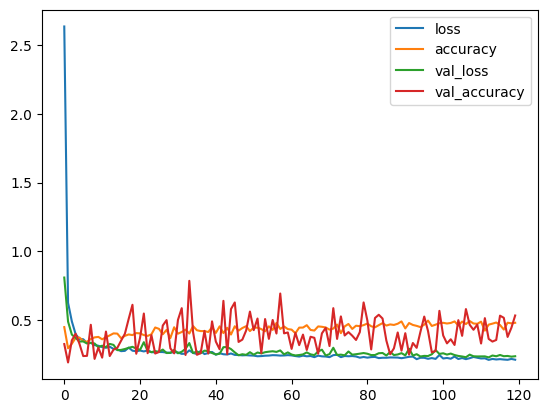

In [96]:
model_loss.plot()

In [97]:
model.save('car_game_model.h5')

In [1]:
import keras
model = keras.models.load_model('car_game_model.h5')

2022-08-24 20:53:05.751815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 20:53:05.810985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-24 20:53:05.811001: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-24 20:53:05.811446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1600, 1200), car_speed=5, frame_rate=60,
                   road=RoadEnum.ONE, sensor_threshold=600, generate_train_data=False, nn_model=model)

car_game.start_game()


pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
1/1 [==============================] - 0s 97ms/step
[[0.48885992 0.51114005]]
1/1 [==============================] - 0s 10ms/step
[[0.93575513 0.06424479]]
left
1/1 [==============================] - 0s 10ms/step
[[0.7130007 0.2869993]]
1/1 [==============================] - 0s 10ms/step
[[0.6909057  0.30909425]]
1/1 [==============================] - 0s 10ms/step
[[0.69994885 0.30005124]]
1/1 [==============================] - 0s 10ms/step
[[0.68806493 0.3119351 ]]
1/1 [==============================] - 0s 10ms/step
[[0.69715583 0.3028441 ]]
1/1 [==============================] - 0s 11ms/step
[[0.6626841  0.33731592]]
1/1 [==============================] - 0s 10ms/step
[[0.67286146 0.32713857]]
1/1 [==============================] - 0s 10ms/step
[[0.6699333  0.33006674]]
1/1 [==============================] - 0s 10ms/step
[[0.556891  0.4431089]]
1/1 [=======================

1/1 [==============================] - 0s 10ms/step
[[0.09348361 0.9065164 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.8063897  0.19361034]]
left
1/1 [==============================] - 0s 10ms/step
[[0.01939402 0.980606  ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00781962 0.99218035]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00861494 0.9913851 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.0182735 0.9817266]]
right
1/1 [==============================] - 0s 10ms/step
[[0.08230464 0.91769534]]
right
1/1 [==============================] - 0s 10ms/step
[[0.02869444 0.9713056 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.00142377 0.9985763 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.2637322 0.7362678]]
1/1 [==============================] - 0s 10ms/step
[[0.53358275 0.46641725]]
1/1 [==============================] - 0s 10ms/step
[[0.001753 0.998247]]
right
1/1 [========

1/1 [==============================] - 0s 10ms/step
[[0.6973193  0.30268067]]
1/1 [==============================] - 0s 11ms/step
[[0.66567695 0.33432308]]
1/1 [==============================] - 0s 10ms/step
[[0.66567695 0.33432308]]
1/1 [==============================] - 0s 10ms/step
[[0.66567695 0.33432308]]
1/1 [==============================] - 0s 10ms/step
[[0.63246745 0.36753255]]
1/1 [==============================] - 0s 9ms/step
[[0.63246745 0.36753255]]
1/1 [==============================] - 0s 10ms/step
[[0.66567695 0.33432308]]
1/1 [==============================] - 0s 10ms/step
[[0.68890464 0.31109536]]
1/1 [==============================] - 0s 10ms/step
[[0.68890464 0.31109536]]
1/1 [==============================] - 0s 10ms/step
[[0.71927637 0.28072363]]
1/1 [==============================] - 0s 10ms/step
[[0.71927637 0.28072363]]
1/1 [==============================] - 0s 10ms/step
[[0.7477712  0.25222886]]
1/1 [==============================] - 0s 10ms/step
[[0.77428    

1/1 [==============================] - 0s 10ms/step
[[0.37898695 0.62101305]]
1/1 [==============================] - 0s 10ms/step
[[0.47256312 0.52743685]]
1/1 [==============================] - 0s 10ms/step
[[0.01295034 0.98704964]]
right
1/1 [==============================] - 0s 10ms/step
[[9.9977332e-01 2.2672625e-04]]
left
1/1 [==============================] - 0s 10ms/step
[[8.525683e-04 9.991474e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[9.9989641e-01 1.0357136e-04]]
left
1/1 [==============================] - 0s 10ms/step
[[0.9730382  0.02696177]]
left
1/1 [==============================] - 0s 10ms/step
[[0.01194486 0.98805517]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9857847  0.01421531]]
left
1/1 [==============================] - 0s 10ms/step
[[3.8732233e-04 9.9961275e-01]]
right
1/1 [==============================] - 0s 10ms/step
[[0.9566945  0.04330556]]
left
1/1 [==============================] - 0s 10ms/step
[[0.0065365 0.99346